<h3>Time Series Modelling using Recursive Neural Networks (RNNs)

Using a climate dataset:

In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv("climate_2009_2016_full.csv") #Larger set out of the two climate datasets (the other is 'climate_2009.csv')
raw_data.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


<h5>Initial Data Inspection:

In [3]:
raw_data.info()
# Fairly large dataset. 400,000+ rows and 14 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
raw_data.isnull().sum()
# No null values...

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [5]:
# Duplicates
unique_rows = raw_data.drop_duplicates().shape[0]
duplicate_rows = len(raw_data) - unique_rows
duplicate_rows

327

In [6]:
# Drop duplicates:
raw_data = raw_data.drop_duplicates()

In [7]:
unique_rows = raw_data.drop_duplicates().shape[0]
duplicate_rows = len(raw_data) - unique_rows
duplicate_rows

0

In [8]:
data = raw_data

<h5>EDA

In [9]:
# 1) Time Indexing: Sequence learning works best when the time column is correctly and consistently formated (e.g. datetime object), is sorted i.e. in order, and has no duplicates.

In [10]:
type(data['Date Time'][0]) #The values in the 'Date Time' column are strings.

str

In [11]:
# Convert them to datetime objects:
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [12]:
type(data['Date Time'][0]) #The values in the 'Date Time' column are strings. # Converted successfully.

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
# check if 'Date Time' is increaing
is_ascending = data['Date Time'].is_monotonic_increasing
print("Ascending:" , is_ascending)

if not is_ascending:
    bad = data['Date Time'] < data['Date Time'].shift(1)
    print("Number of disorderings:", bad.sum())
    display(data.loc[bad, ['Date Time']].head(10))

Ascending: True


In [14]:
# check if 'Date Time' is evenly spaced
deltas = data['Date Time'].diff().iloc[1:]
mode = deltas.mode().iloc[0]
mode_count = (deltas == mode).sum()

if deltas.nunique() == 1:
    print("Evenly spaced. Interval =", mode)
else:
    total = len(deltas)
    print("Not evenly spaced.")
    print(f"Most common interval: {mode} ({mode_count}/{total} = {mode_count/total:.4%})")
    print("\nTop different intervals:")
    print(deltas.value_counts().head(10))
    print("\nFirst examples of intervals != most common:")
    print(deltas[deltas != mode].head(10))

Not evenly spaced.
Most common interval: 0 days 00:10:00 (420218/420223 = 99.9988%)

Top different intervals:
Date Time
0 days 00:10:00    420218
0 days 00:20:00         2
0 days 00:30:00         1
0 days 16:00:00         1
3 days 02:20:00         1
Name: count, dtype: int64

First examples of intervals != most common:
40378    0 days 00:30:00
230019   0 days 00:20:00
293556   0 days 00:20:00
301673   0 days 16:00:00
411267   3 days 02:20:00
Name: Date Time, dtype: timedelta64[ns]


In [15]:
# Will leave this unthouched for now. If it affects the model then we will do something about it. 
# It shouldn't be as an overwhelming majority of the data is evenly spaced (99.99%+ of rows).

In [16]:
# Will use what was done in the tutorial regarding extraction of rows at greater time intervals i.e. 'shrinking' the data.
# Extract hourly data:
data = data.iloc[::6].copy()
print(f"Original data shape: {data.shape}")
print(f"Hourly data shape: {data.shape}")
data.head()

Original data shape: (70038, 15)
Hourly data shape: (70038, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
6,2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
12,2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
18,2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
24,2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


In [17]:
# Calculate time interval between consecutive rows
time_interval = data['Date Time'].diff().iloc[1]
print(f"Time interval between rows: {time_interval}")
# We now have 1 hour intervals

Time interval between rows: 0 days 01:00:00


In [18]:
# 2) Time trends: How does each column change over time?

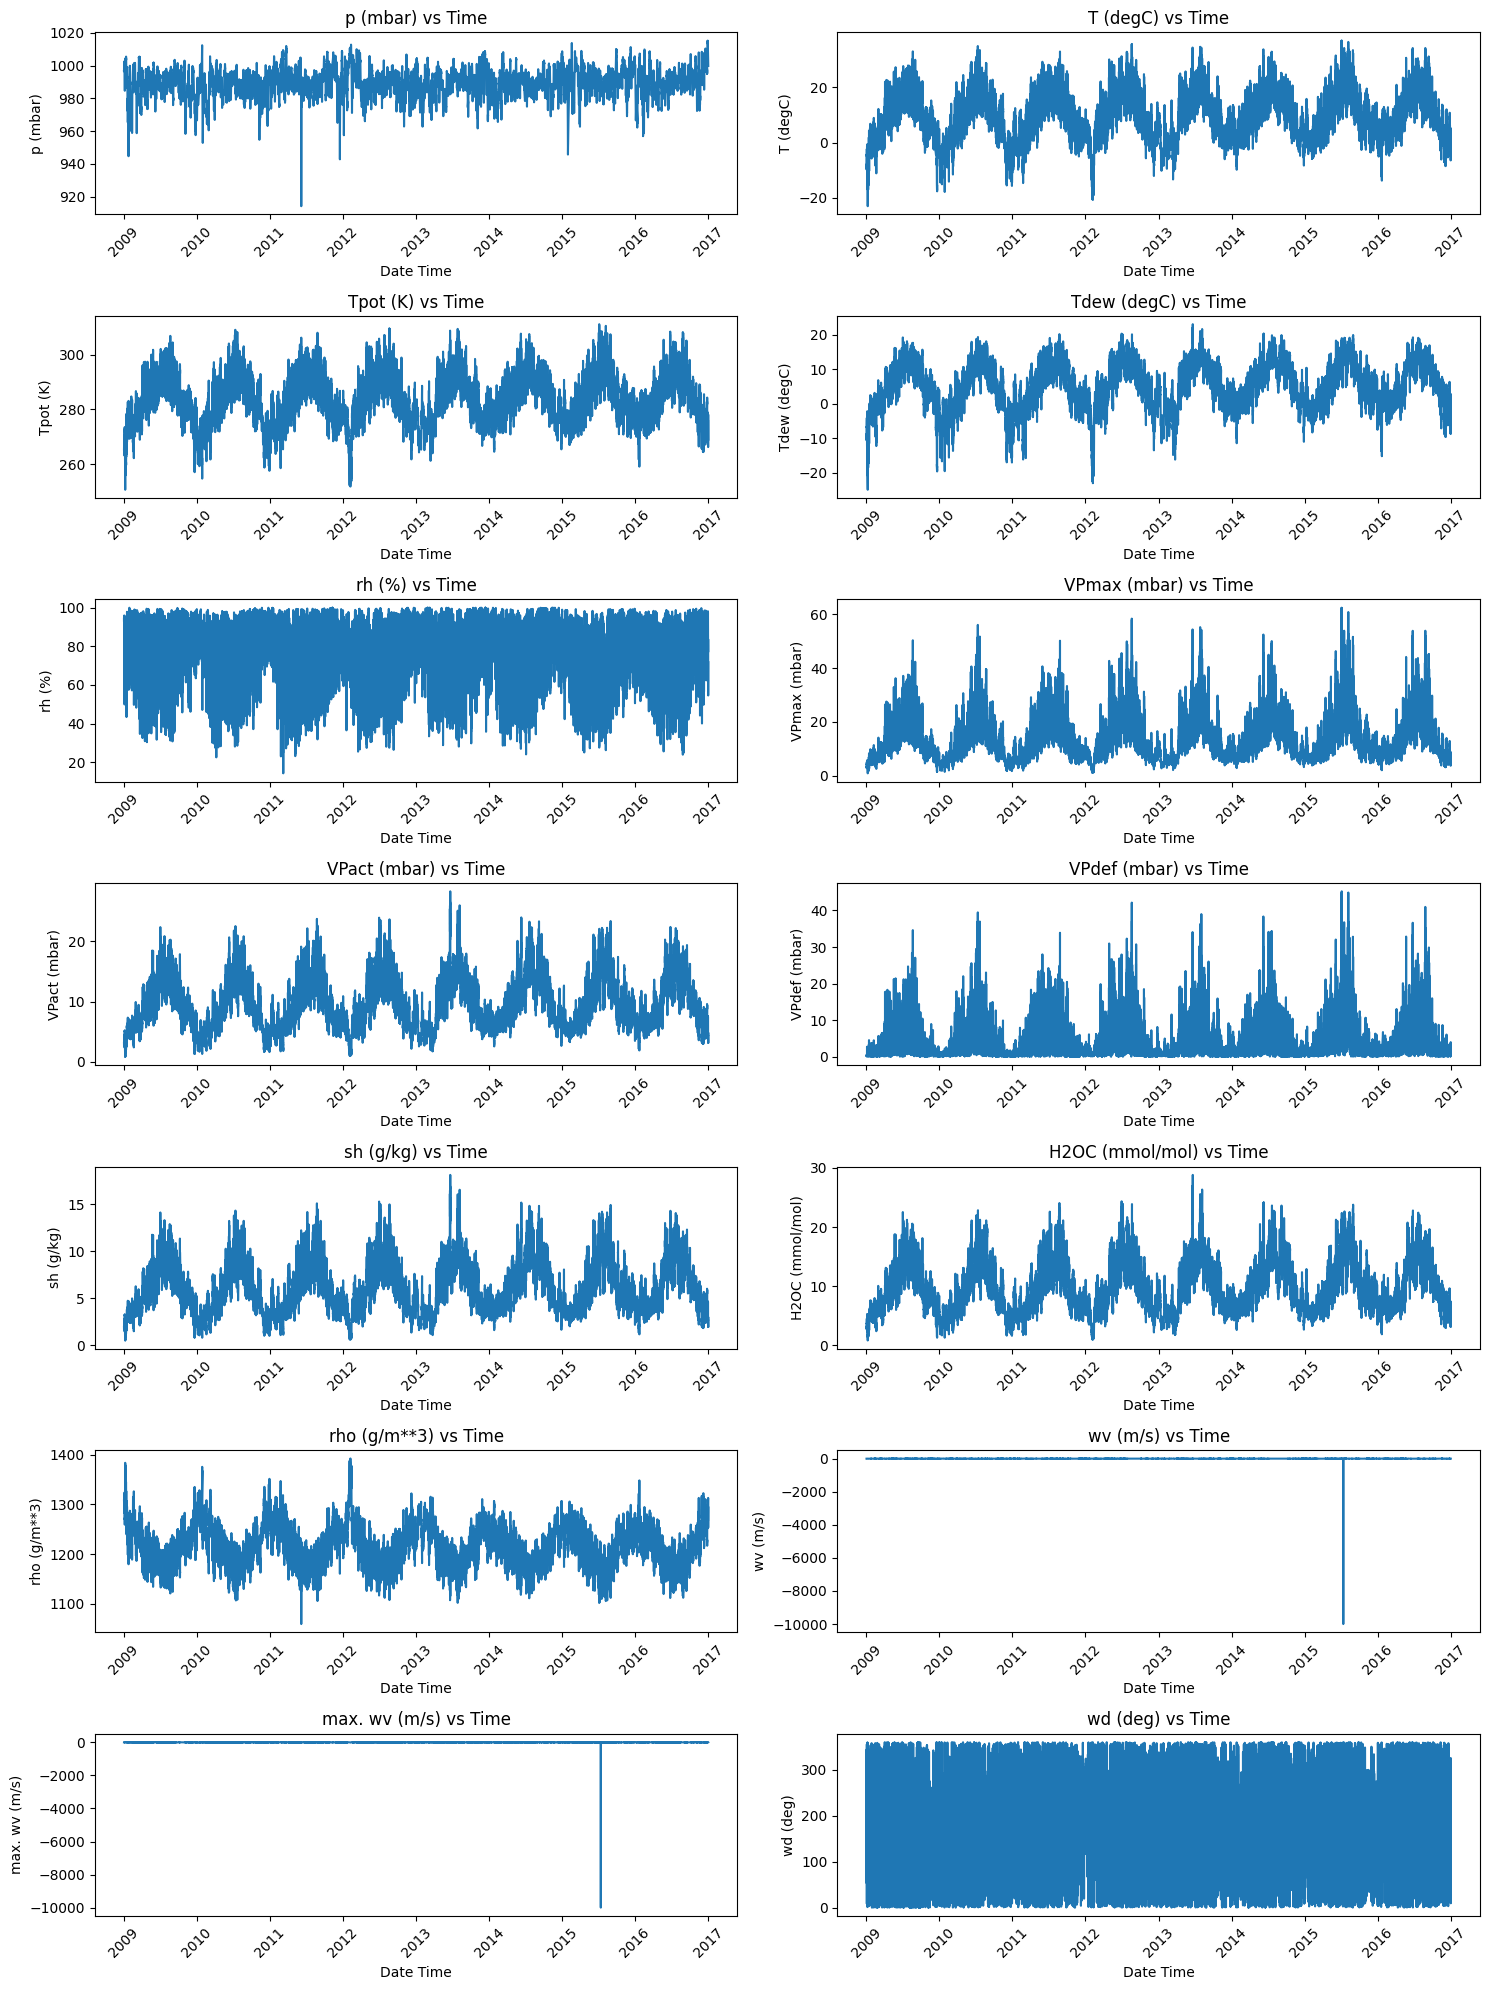

In [19]:
import matplotlib.pyplot as plt

# Create a grid plot of each column vs time
fig, axes = plt.subplots(7, 2, figsize=(15, 20))
axes = axes.flatten()

# Get numeric columns (excluding Date Time)
numeric_cols = data.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_cols):
    axes[i].plot(data['Date Time'], data[col])
    axes[i].set_title(f'{col} vs Time')
    axes[i].set_xlabel('Date Time')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove the last empty subplot if there's an odd number of columns
if len(numeric_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()
# There appears to be seasonality in the data. This isn't suprising as we are dealing with weather data.

In [20]:
# Will only be dealing with time and temperature for now (may be interesting to see if additional columns (e.g pressure) could be implemented to
# try and predict future temperature).

In [21]:
# Create a new dataframe with only Date Time and temperature columns
tt_data = data[['Date Time', 'T (degC)']].copy()
tt_data.columns = ['Date Time','Temperature']
tt_data.head()

,Date Time,Temperature
0,2009-01-01 00:10:00,-8.02
6,2009-01-01 01:10:00,-7.62
12,2009-01-01 02:10:00,-8.85
18,2009-01-01 03:10:00,-8.84
24,2009-01-01 04:10:00,-9.23


In [22]:
tt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70038 entries, 0 to 420549
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Time    70038 non-null  datetime64[ns]
 1   Temperature  70038 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 MB


In [23]:
tt_data = tt_data.reset_index(drop=True)
tt_data.head()

,Date Time,Temperature
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 01:10:00,-7.62
2,2009-01-01 02:10:00,-8.85
3,2009-01-01 03:10:00,-8.84
4,2009-01-01 04:10:00,-9.23


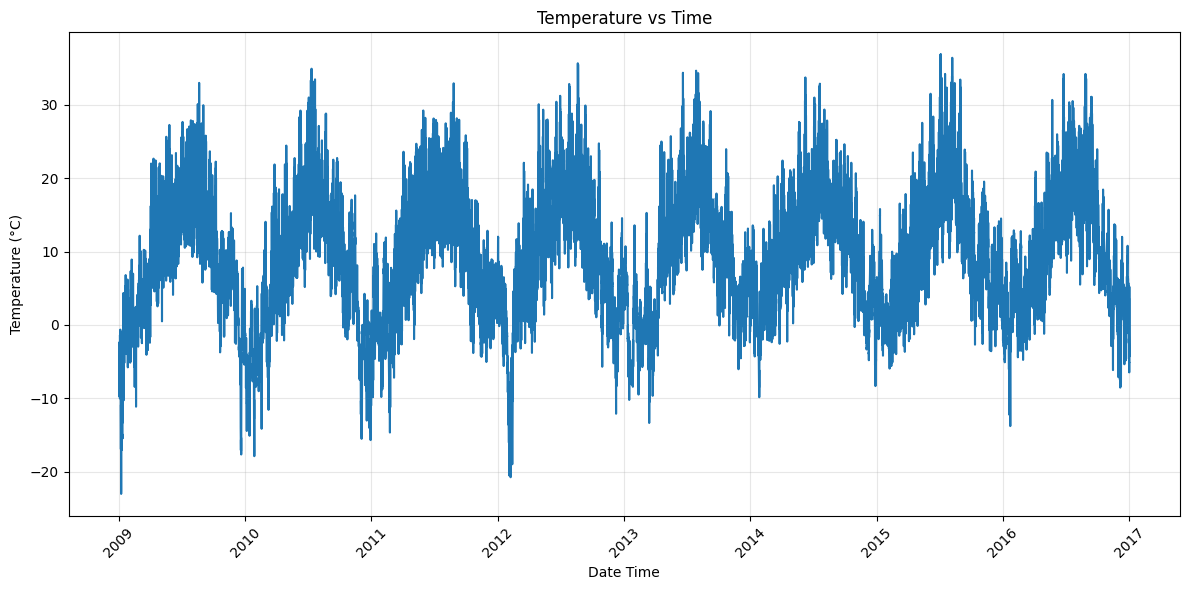

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(tt_data['Date Time'], tt_data['Temperature'])
plt.title('Temperature vs Time')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
# Appears to be quite noisiy like the rest of the columns in the previous gridplot.

In [26]:
# 3) Data Distribution:

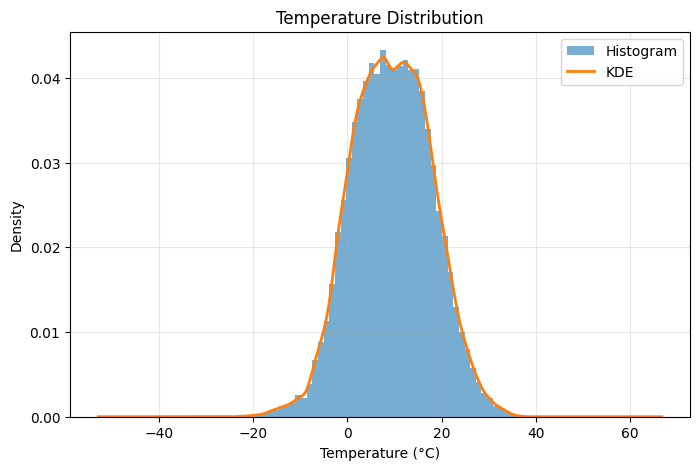

In [27]:
plt.figure(figsize=(8,5))
ax = tt_data['Temperature'].plot.hist(bins=50, density=True, alpha=0.6, label='Histogram')
tt_data['Temperature'].plot.kde(label='KDE', lw=2, ax=ax)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [28]:
# Doesn't seem to be a significant number of outliers based on visual distribution.

In [29]:
# Using values that fall outside the IQR:
Q1 = tt_data["Temperature"].quantile(0.25)
Q3 = tt_data["Temperature"].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = tt_data[
    (tt_data["Temperature"] < Q1 - 1.5 * IQR) |
    (tt_data["Temperature"] > Q3 + 1.5 * IQR)
]
print(f"Number of outliers (according to IQR):{outliers_iqr.shape[0]}")
print(f"Percentage of data:{round(outliers_iqr.shape[0]*100/tt_data.shape[0],4)}%")
outliers_iqr


Number of outliers (according to IQR):252
Percentage of data:0.3598%


,Date Time,Temperature
125,2009-01-06 05:10:00,-15.20
126,2009-01-06 06:10:00,-15.49
127,2009-01-06 07:10:00,-16.92
128,2009-01-06 08:10:00,-16.26
129,2009-01-06 09:10:00,-15.69
...,...,...
65543,2016-06-24 15:40:00,34.19
65544,2016-06-24 16:40:00,33.97
67055,2016-08-26 15:40:00,34.18
67056,2016-08-26 16:40:00,34.20


In [30]:
# Still a tiny amount of outliers. Will see if this affects the model.

<h5>Pre Processing

In [31]:
temperature_column = tt_data["Temperature"] # Make sure to provide a single column df (we are using pst-temperature to predict future-temperature)

In [32]:
# Order of processing:

# 1) Split into train/validate/test sets (by time)
# 2) Scale the data.
# 3) Generate sequences

In [33]:
# Cannot do a random split as it will mess with the time intervals.
# Time-ordered 6:1:3 split of temperature_column (no shuffle)
n = len(temperature_column)
train_end = int(n * 0.6)
val_end = train_end + int(n * 0.1)

temp_train = temperature_column.iloc[:train_end].reset_index(drop=True) #Training
temp_val = temperature_column.iloc[train_end:val_end].reset_index(drop=True) #Validation
temp_test = temperature_column.iloc[val_end:].reset_index(drop=True) #Testing

print(f"Train: {temp_train.shape}, Val: {temp_val.shape}, Test: {temp_test.shape}")

Train: (42022,), Val: (7003,), Test: (21013,)


In [34]:
# Scaling the data:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # Because it contains outliers

# sklearn scalers expect 2D input. Convert the Series to a single-column DataFrame
# and keep the result as a DataFrame for downstream code that expects df.to_numpy().
train_scaled = pd.DataFrame(scaler.fit_transform(temp_train.to_frame()),
							index=temp_train.index, columns=['Temperature'])
val_scaled = pd.DataFrame(scaler.transform(temp_val.to_frame()),
						  index=temp_val.index, columns=['Temperature'])
test_scaled = pd.DataFrame(scaler.transform(temp_test.to_frame()),
						   index=temp_test.index, columns=['Temperature'])

In [35]:
# Need to transform the data into:

# X = A series of arrays containing the last n temperature readings. The shape of X is (l, n), where l is the number of rows in the dataset.
# y= An array of temperature readings as a function of time.

# e.g if the data looked like this: [1,2,3,4,5,6,7], and n = 3,
# X[0] = [1,2,3], Y[0] = 4
# X[1] = [2,3,4], Y[1] = 5
# etc

# Every label is ahead by n values. It's looking ahead such that a value contains the previous n values.

def LSTM_input(df, input_sequence):
    """
    Generate supervised learning sequences from a time-ordered dataset
    for one-step-ahead LSTM forecasting.

    This function converts a time-series DataFrame into sliding input
    sequences (X) and corresponding target values (y), suitable for
    training a many-to-one LSTM model.

    For each sample:
        - X contains `input_sequence` consecutive past observations
        - y contains the immediately following observation

    The function assumes the data is:
        - Ordered in ascending chronological order (oldest → newest)
        - Free of non-numeric columns (e.g. time columns removed)
        - Already scaled or normalised, if required

    Parameters
    ----------
    df : pandas.DataFrame
        Time-series data containing one or more numeric features.
        Shape: (n_samples, n_features).
        The index or original time column is not used by this function.

    input_sequence : int
        Number of past time steps to include in each input sequence
        (i.e. the LSTM lookback window).

    Returns
    -------
    X : numpy.ndarray
        Array of input sequences with shape:
            (n_samples - input_sequence, input_sequence, n_features)

    y : numpy.ndarray
        Array of target values with shape:
            (n_samples - input_sequence, n_features)

    Notes
    -----
    - This function performs one-step-ahead forecasting.
    - Each target value corresponds to the time step immediately
      following its input sequence.
    - The function does not shuffle data and preserves temporal order.
    - The function does not perform any scaling or missing-value handling.

    Example
    -------
    >>> X, y = Sequential_Input_LSTM(df_scaled, input_sequence=28)
    >>> X.shape
    (num_samples, 28, num_features)
    >>> y.shape
    (num_samples, num_features)
    """
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)

In [36]:
historical_inputs = 10 #Uses the past 10 points.
X_train, y_train = LSTM_input(train_scaled,historical_inputs)
X_val, y_val = LSTM_input(val_scaled,historical_inputs)
X_test, y_test = LSTM_input(test_scaled,historical_inputs)

In [42]:
# Show shapes of processed datasets
datasets = {
    "X_train": X_train.shape,
    "y_train": y_train.shape,
    "X_val": X_val.shape,
    "y_val": y_val.shape,
    "X_test": X_test.shape,
    "y_test": y_test.shape,
}

for name, shape in datasets.items():
    print(f"{name}: {shape}")
# The datasets have the correct shape and are ready to be used with a model
# shape = (rows, historical_inputs, features)
# features should be 1 as we provide one column from the original dataset i.e. temperature.

X_train: (42012, 10, 1)
y_train: (42012, 1)
X_val: (6993, 10, 1)
y_val: (6993, 1)
X_test: (21003, 10, 1)
y_test: (21003, 1)


<h5>Creating the Model

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

In [73]:
# Starting with a single LSTM layer model

lookback_length = X_train.shape[1] #Self explanatory. Should be 10 here.
features = X_train.shape[2]

model_1 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=False), # If not False, the dimnesionality of the predictions can be = rows*look_back_length
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'linear') #This is a regression problem of continuous and unbound values. No artificial constraints should be placed.
])

model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
#Implement early stopping to

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model_1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

In [75]:
model_1_history = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1155 - root_mean_squared_error: 0.3398 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2340
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0481 - root_mean_squared_error: 0.2192 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1511
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1235 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step 

In [58]:
# Function to plot training + validation loss and RMSE from the trained model:
def training_validation_curve(model_history,model_name):

    history = model_history.history
    epochs = range(1, len(history.get('loss', [])) + 1)

    rmse_key = next((k for k in history.keys() if ('root' in k.lower() or 'rmse' in k.lower()) and not k.startswith('val_')), None)
    val_rmse_key = next((k for k in history.keys() if k.startswith('val_') and (('root' in k.lower() or 'rmse' in k.lower()))), None)

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    axs[0].plot(epochs, history.get('loss', []), label='train loss')
    if 'val_loss' in history:
        axs[0].plot(epochs, history['val_loss'], label='val loss')
    axs[0].set_title(f'{model_name} Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('MSE')
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    if rmse_key:
        axs[1].plot(epochs, history.get(rmse_key, []), label='train RMSE')
        if val_rmse_key:
            axs[1].plot(epochs, history.get(val_rmse_key, []), label='val RMSE')
        axs[1].set_title(f'{model_name} Root Mean Squared Error')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('RMSE')
        axs[1].legend()
        axs[1].grid(alpha=0.3)
    else:
        axs[1].text(0.5, 0.5, 'No RMSE metric found in history', ha='center', va='center')
        axs[1].set_axis_off()

    plt.tight_layout()
    plt.show()

    # Evaluate model on validation and test sets (returns [loss, rmse])
    val_metrics = model_1.evaluate(X_val, y_val, verbose=0)
    test_metrics = model_1.evaluate(X_test, y_test, verbose=0)

    print(f"{model_name} Results:")
    print(f"Validation -> loss: {val_metrics[0]:.6f}, rmse: {val_metrics[1]:.6f}")
    print(f"Test       -> loss: {test_metrics[0]:.6f}, rmse: {test_metrics[1]:.6f}")

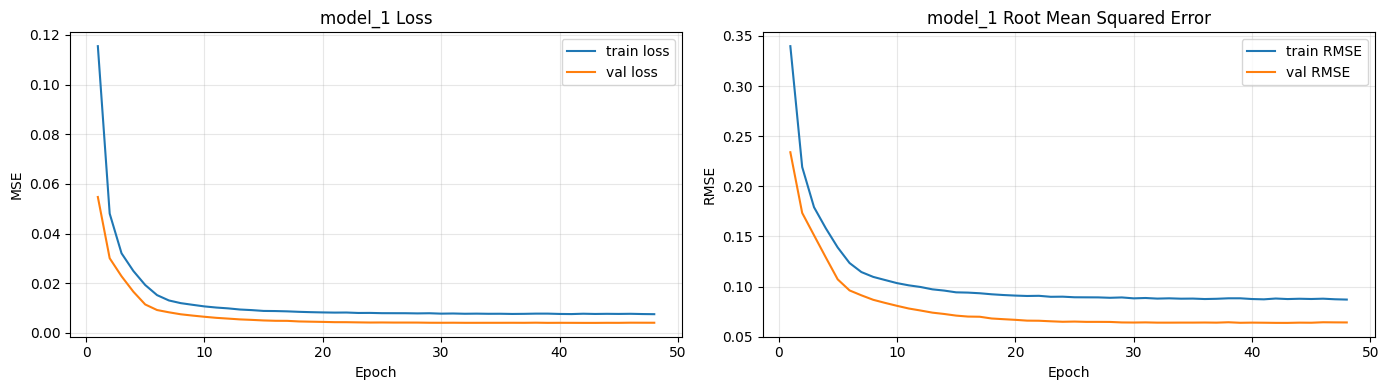

model_1 Results:
Validation -> loss: 0.004116, rmse: 0.064153
Test       -> loss: 0.003907, rmse: 0.062506


In [76]:
training_validation_curve(model_1_history,"model_1")

In [77]:
model_1_y_predictions = model_1.predict(X_test)

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate_time_series_forecast(y_true,y_pred,plot_points=300,):
    
    # --- Ensure 1D arrays ---
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    # --- Core metrics ---
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    residuals = y_true - y_pred
    residual_mean = residuals.mean()

    # --- Naive (persistence) baseline ---
    naive_pred = y_true[:-1]
    naive_true = y_true[1:]
    mae_naive = mean_absolute_error(naive_true, naive_pred)

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "Residual mean": residual_mean,
        "Naive MAE": mae_naive
    }

    # --- Print metrics ---
    print("Forecast evaluation metrics")
    print("-" * 30)
    for k, v in metrics.items():
        print(f"{k:15s}: {v:.4f}")

    # --- Plot: actual vs predicted ---
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:plot_points], label="Actual")
    plt.plot(y_pred[:plot_points], label="Predicted")
    plt.title("Actual vs Predicted")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # --- Plot: residuals over time ---
    plt.figure(figsize=(12, 3))
    plt.plot(residuals[:plot_points])
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title("Residuals over time")
    plt.ylabel("Error")
    plt.show()

    # --- Plot: residual distribution ---
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=50)
    plt.title("Residual distribution")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.show()

    # --- Plot: predicted vs actual scatter ---
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()),
            max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, linestyle="--", color="black")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.show()

    return metrics


Forecast evaluation metrics
------------------------------
MAE            : 0.0428
RMSE           : 0.0625
Residual mean  : 0.0027
Naive MAE      : 0.0552


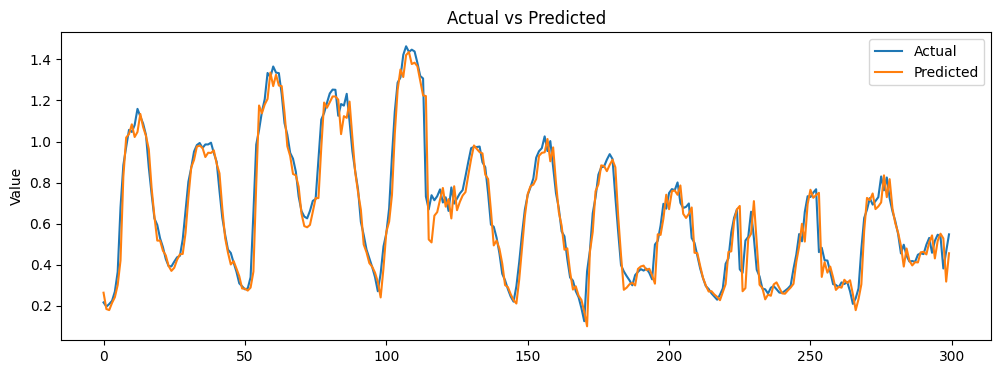

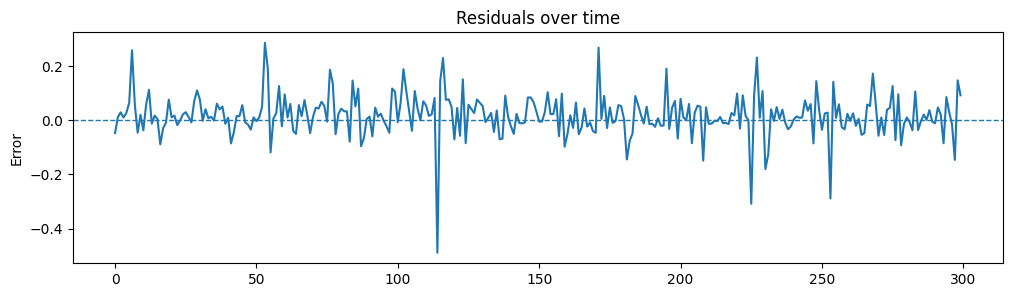

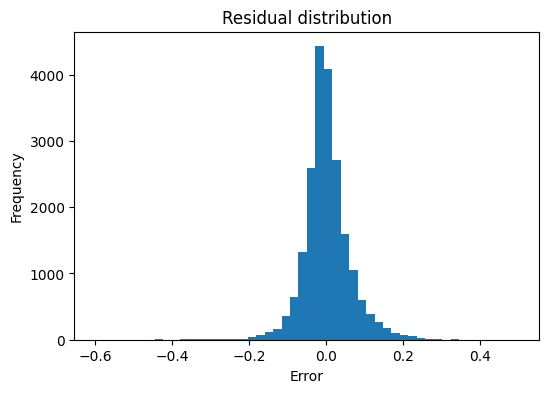

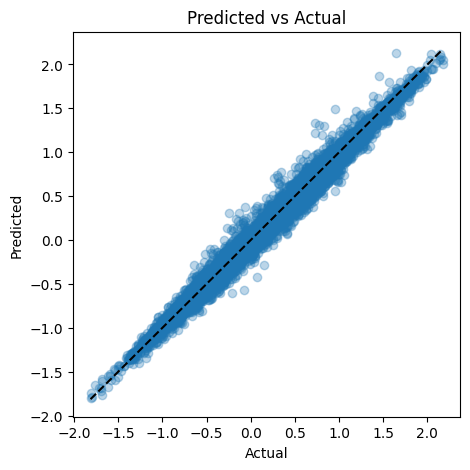

In [84]:
model_1_prediction_metrics = evaluate_time_series_forecast(y_test,model_1_y_predictions)

In [86]:
# The model, with only one hidden layer, seems to already be pretty accurate...

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

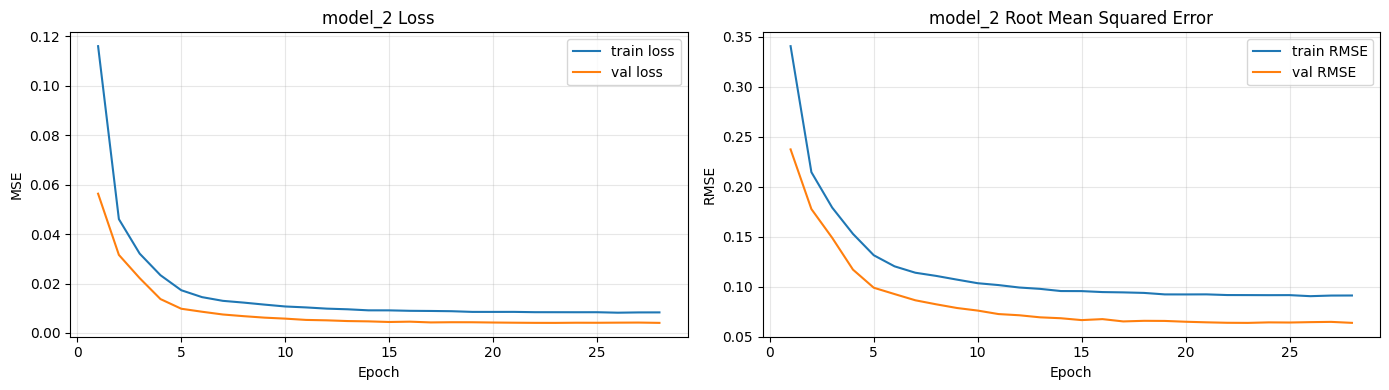

model_2 Results:
Validation -> loss: 0.004116, rmse: 0.064153
Test       -> loss: 0.003907, rmse: 0.062506
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Forecast evaluation metrics
------------------------------
MAE            : 0.0425
RMSE           : 0.0622
Residual mean  : 0.0040
Naive MAE      : 0.0552


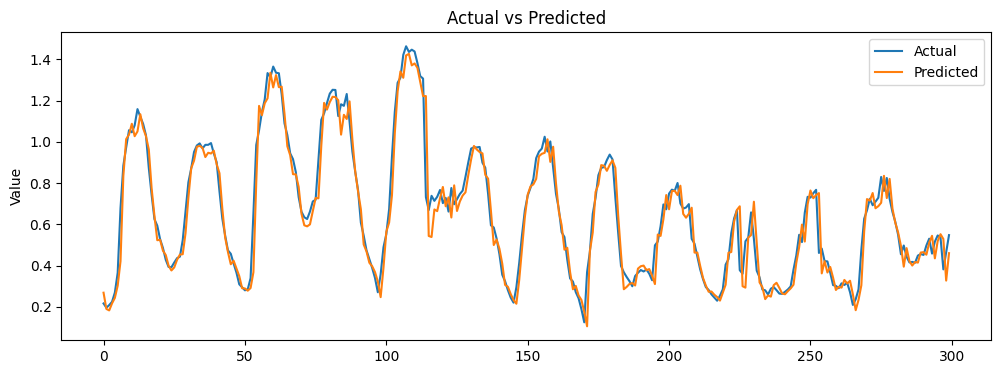

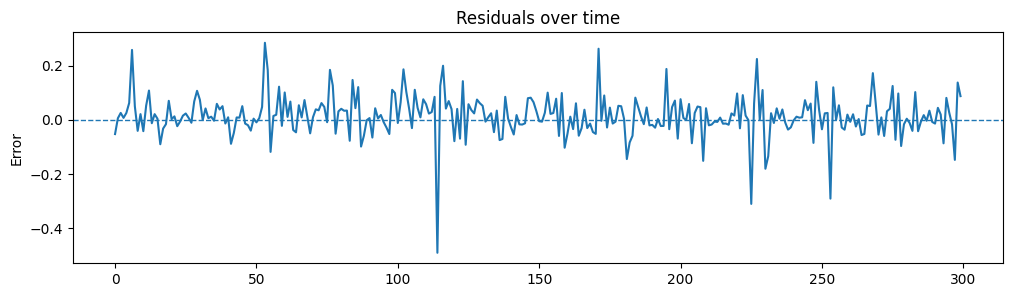

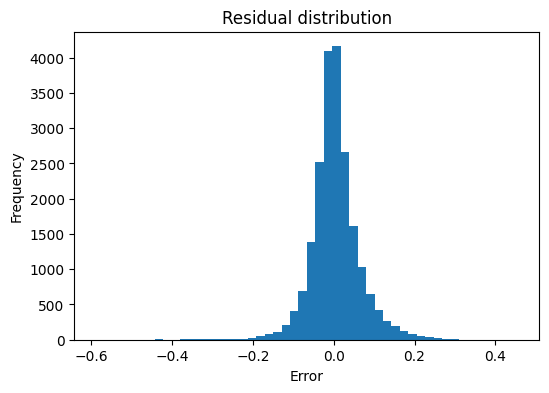

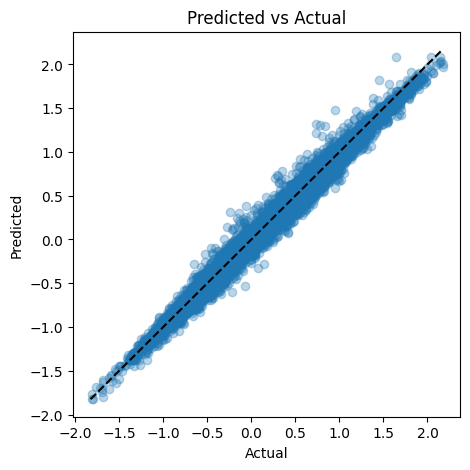

In [89]:
# Model 2: Adding an extra LSTM layer:

lookback_length = X_train.shape[1]
features = X_train.shape[2]

model_2 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=True), #Need to return sequences between layers, but keep last one False...
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'linear')
])

model_2.summary()

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model_2.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

model_2_history = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

training_validation_curve(model_2_history,"model_2")

model_2_y_predictions = model_2.predict(X_test)

model_2_prediction_metrics = evaluate_time_series_forecast(y_test,model_2_y_predictions)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

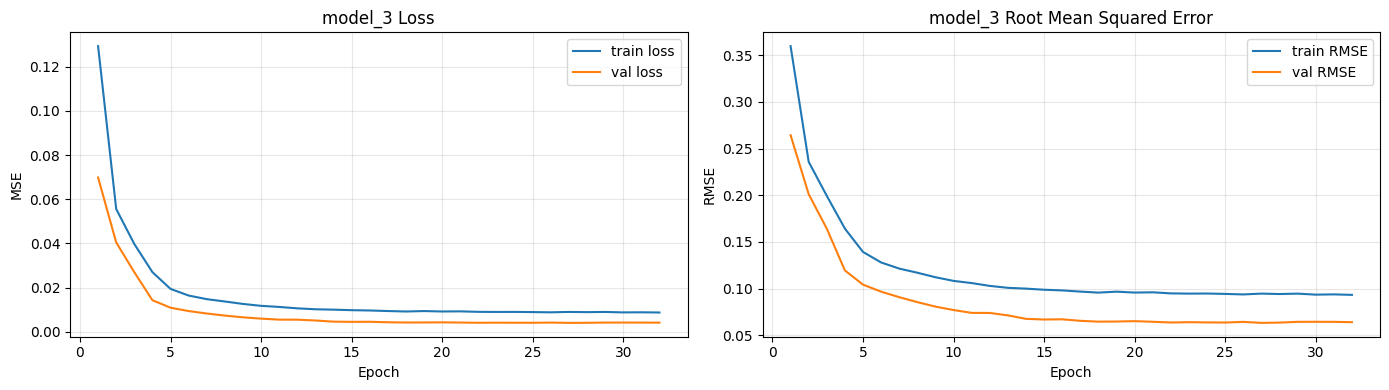

model_3 Results:
Validation -> loss: 0.004116, rmse: 0.064153
Test       -> loss: 0.003907, rmse: 0.062506
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Forecast evaluation metrics
------------------------------
MAE            : 0.0435
RMSE           : 0.0626
Residual mean  : 0.0021
Naive MAE      : 0.0552


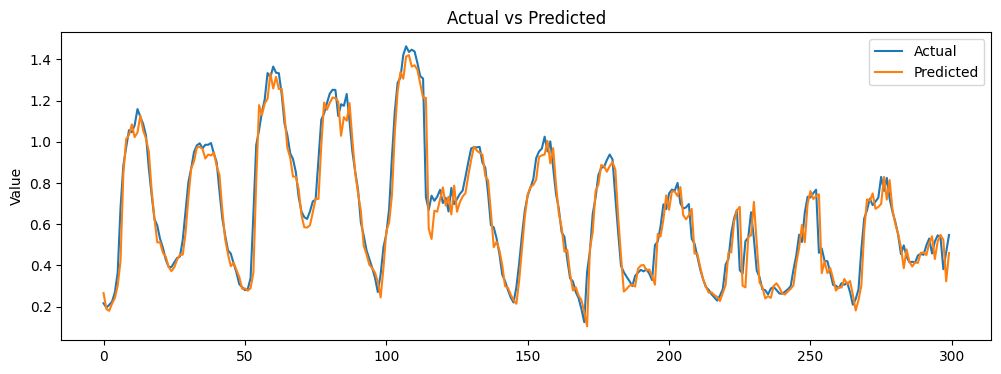

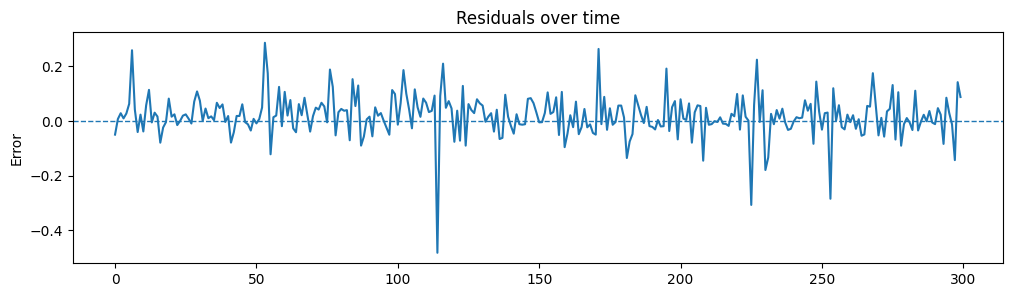

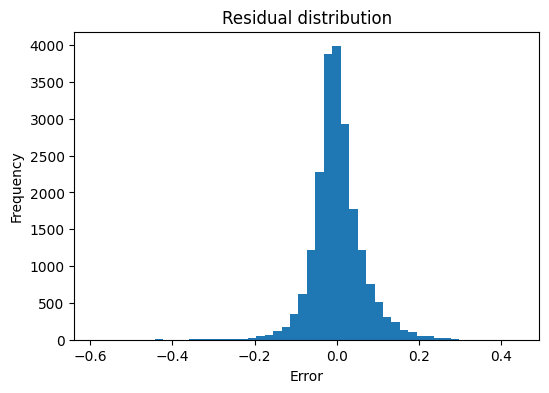

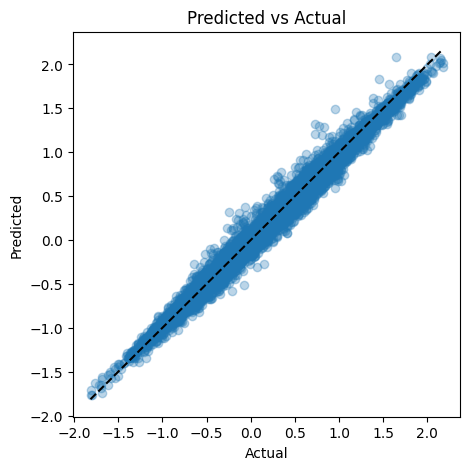

In [90]:
# Model 3: Adding a third LSTM layer:

lookback_length = X_train.shape[1]
features = X_train.shape[2]

model_3 = keras.Sequential([
    keras.layers.Input(shape=(lookback_length,features)),
    keras.layers.LSTM(64, return_sequences=True), #Need to return sequences between layers, but keep last one False...
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'linear')
])

model_3.summary()

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model_3.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = [RootMeanSquaredError()])

model_3_history = model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

training_validation_curve(model_3_history,"model_3")

model_3_y_predictions = model_3.predict(X_test)

model_3_prediction_metrics = evaluate_time_series_forecast(y_test,model_3_y_predictions)

In [ ]:
# Create comparison dataframe of model metrics
comparison_df = pd.DataFrame({
    'model_1': pd.Series(model_1_prediction_metrics),
    'model_2': pd.Series(model_2_prediction_metrics),
    'model_3': pd.Series(model_3_prediction_metrics),
}).T
cols = ['MAE', 'RMSE', 'Residual mean', 'Naive MAE']
comparison_df = comparison_df[cols]

comparison_df

,MAE,RMSE,Residual mean,Naive MAE
model_1,0.042817,0.062506,0.002703,0.055157
model_2,0.042503,0.062161,0.003974,0.055157
model_3,0.043516,0.062630,0.002078,0.055157


In [92]:
# We get very marginal positive changes by implementing more layers (and therefore increasing computational cost).